In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
import datetime as dt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("COVID19BE_CASES_AGESEX.csv")

In [3]:
def get_time_series_province(province):
    pd.options.mode.chained_assignment = None  
    df_updated = df.dropna(axis=0)
    df_province = df_updated[(df_updated['PROVINCE'] == province)]
    df_province["DATE"] = pd.to_datetime(df_province["DATE"], format='%Y-%m-%d')
    df_province["DATE"] = df_province["DATE"].dt.strftime("%Y%m%d").astype(int)
    df_province.drop(["REGION","AGEGROUP","SEX"], axis=1,inplace=True)
    return df_province.groupby("DATE").sum()
    #df_province = df_province.groupby('df_province['DATE']').sum()    
    #return df_province.set_index('DATE')["CASES"]

In [4]:
def get_time_series_total():
    pd.options.mode.chained_assignment = None  
    df_updated = df.dropna(axis=0)

    df_updated["DATE"] = pd.to_datetime(df_updated["DATE"], format='%Y-%m-%d')
    df_updated["DATE"] = df_updated["DATE"].dt.strftime("%Y%m%d").astype(int)
    df_updated.drop(["REGION","AGEGROUP","SEX"], axis=1,inplace=True)
    return df_updated.groupby('DATE').sum()

In [5]:
#pd.options.mode.chained_assignment = None  
#df_updated["DATE"] = pd.to_datetime(df_updated["DATE"], format='%Y-%m-%d')
#df_updated["DATE"] = df_updated["DATE"].dt.strftime("%Y%m%d").astype(int)
#df_updated.drop(["REGION","AGEGROUP","SEX"], axis=1,inplace=True)
df_updated = get_time_series_province('Antwerpen')

In [6]:
# df_updated = df_updated.groupby('DATE').sum()

In [7]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_updated)

In [8]:
# split into train and test sets
train_size = int(len(dataset) * 0.95)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

292 16


In [9]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [11]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [12]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
290/290 - 1s - loss: 0.0294
Epoch 2/50
290/290 - 0s - loss: 0.0231
Epoch 3/50
290/290 - 0s - loss: 0.0202
Epoch 4/50
290/290 - 0s - loss: 0.0173
Epoch 5/50
290/290 - 0s - loss: 0.0149
Epoch 6/50
290/290 - 0s - loss: 0.0127
Epoch 7/50
290/290 - 0s - loss: 0.0111
Epoch 8/50
290/290 - 0s - loss: 0.0102
Epoch 9/50
290/290 - 0s - loss: 0.0095
Epoch 10/50
290/290 - 0s - loss: 0.0095
Epoch 11/50
290/290 - 0s - loss: 0.0093
Epoch 12/50
290/290 - 0s - loss: 0.0093
Epoch 13/50
290/290 - 0s - loss: 0.0093
Epoch 14/50
290/290 - 0s - loss: 0.0093
Epoch 15/50
290/290 - 0s - loss: 0.0094
Epoch 16/50
290/290 - 0s - loss: 0.0093
Epoch 17/50
290/290 - 0s - loss: 0.0093
Epoch 18/50
290/290 - 0s - loss: 0.0093
Epoch 19/50
290/290 - 0s - loss: 0.0093
Epoch 20/50
290/290 - 0s - loss: 0.0092
Epoch 21/50
290/290 - 0s - loss: 0.0093
Epoch 22/50
290/290 - 0s - loss: 0.0093
Epoch 23/50
290/290 - 0s - loss: 0.0093
Epoch 24/50
290/290 - 0s - loss: 0.0093
Epoch 25/50
290/290 - 0s - loss: 0.0093
Epoch 26/

In [13]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 221.00 RMSE
Test Score: 184.13 RMSE


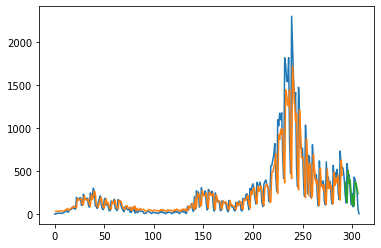

In [14]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [15]:
print(get_time_series_province('Antwerpen'))

          CASES
DATE           
20200301      1
20200302      1
20200303      5
20200304      6
20200305     11
...         ...
20201229    402
20201230    338
20201231    260
20210101     50
20210102      2

[308 rows x 1 columns]


In [27]:
date = pd.to_datetime("2020-12-29", format='%Y-%m-%d')
date = dt.datetime.strftime(date, '%Y%m%d')
date = int(date)
x_input = np.array([date]).reshape(1, -1)
x_input = scaler.fit_transform(x_input)
x_input = np.reshape(x_input, (1,1,1))
yhat = model.predict(x_input, verbose=0)
yhat = scaler.inverse_transform(yhat)
print(yhat)

[[20201230.]]
